In [68]:
import pandas as pd
import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,roc_curve, auc
import keras
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, Flatten,ConvLSTM2D,RepeatVector,Dropout, Bidirectional, Dense, LSTM, GRU,Conv1D, SeparableConv1D,MaxPooling1D,MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import tensorflow as tf
from keras import backend as k
from sklearn.preprocessing import MinMaxScaler
import random
#import data
df = pd.read_csv('https://raw.githubusercontent.com/Truong-Thai-Bao/aqi_airqualitydata_2020/main/aqi_airqualitydata_2020_en.csv')
df

,Date,Country,City,Specie,count,min,max,median,variance
0,17/07/2020,VN,Ho Chi Minh City,temperature,24,26.0,34.0,29.5,59.13
1,21/10/2020,VN,Ho Chi Minh City,temperature,24,26.0,31.0,27.0,26.23
2,07/11/2020,VN,Ho Chi Minh City,temperature,24,25.0,32.5,28.0,69.20
3,22/11/2020,VN,Ho Chi Minh City,temperature,24,24.0,33.5,26.0,102.39
4,10/01/2020,VN,Ho Chi Minh City,temperature,24,23.5,34.0,28.5,125.65
...,...,...,...,...,...,...,...,...,...
16222,26/02/2020,VN,Ha Long,co,28,1.0,9.0,4.0,88.19
16223,27/02/2020,VN,Ha Long,co,34,2.0,9.0,8.0,48.52
16224,29/02/2020,VN,Ha Long,co,22,8.0,9.0,8.0,2.27
16225,24/06/2020,VN,Ha Long,co,48,4.0,8.0,5.0,13.36


#Xem tổng quan dữ liệu

In [69]:
print(df.dtypes)

Date         object
Country      object
City         object
Specie       object
count         int64
min         float64
max         float64
median      float64
variance    float64
dtype: object


In [70]:
df.isnull().sum()

,0
Date,0
Country,0
City,0
Specie,0
count,0
min,0
max,0
median,0
variance,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16227 entries, 0 to 16226
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      16227 non-null  object 
 1   Country   16227 non-null  object 
 2   City      16227 non-null  object 
 3   Specie    16227 non-null  object 
 4   count     16227 non-null  int64  
 5   min       16227 non-null  float64
 6   max       16227 non-null  float64
 7   median    16227 non-null  float64
 8   variance  16227 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.1+ MB


##Kiểm tra unique

In [72]:
#Xem unique các cột không phải là số
cols = ['Country','City','Specie']
for col in cols:
  print(df[col].unique())

['VN']
['Ho Chi Minh City' 'Hue' 'Ha Noi' 'Hai Phong' 'Ha Long']
['temperature' 'humidity' 'wind speed' 'wind-speed' 'wind-gust' 'pm25'
 'dew' 'pressure' 'wind gust' 'co' 'pm10' 'so2' 'no2' 'o3' 'aqi'
 'precipitation']


- Cột 'Country' chỉ có một giá trị là 'VN' nên đây là dữ liệu không có giá trị phân tích. Ta có thể loại bỏ nó ở bước tiền xử lí dữ liệu

- Ta nhận thấy có hai cặp "Specie" có tên khá giống nhau là: (wind speed với wind-speed) và (wind-gust với wind gust) nên có thể dữ liệu sẽ bị trùng lặp. Ta tiến hành thêm các bước kiểm tra để làm rõ.
- Do ta chỉ phân tích trên dữ liệu ở Thành phố Hồ Chí Minh nên sẽ lượt bỏ hết các 'City' còn lại.

#Tiền xử lí dữ liệu

## Bỏ cột 'Country'

In [73]:
# Bỏ các dòng trùng lắp
df = df.drop_duplicates()

In [74]:
#Tạo df chỉ có Ho Chi Minh City
df_hcm = df[df['City']=='Ho Chi Minh City']

In [75]:
df_hcm['Specie'].unique()

array(['temperature', 'humidity', 'wind speed', 'wind-speed', 'wind-gust',
       'pm25', 'dew', 'pressure', 'wind gust'], dtype=object)

In [76]:
#Loại bỏ cột country
df_hcm = df_hcm.drop(columns=['Country'])
#Loại bỏ cột City
df_hcm = df_hcm.drop(columns=['City'])
# Bỏ các dòng wind gust
df_hcm = df_hcm[~df_hcm['Specie'].isin(['wind gust', 'wind-gust'])]

In [77]:
#Xem số lượng từng loại
print(df_hcm[df_hcm['Specie']=='wind speed'].shape[0])
print(df_hcm[df_hcm['Specie']=='wind-speed'].shape[0])

74
300


- Đối với loại không có dấu "-" thì chúng luôn nhỏ hơn so với loại có dấu "-" nên rất có thể chúng đã bị trùng lắp. Hay nói cách khác, không có dấu "-" là 'con' của có dấu "-".

In [78]:
#Chuyển Date sang dạng datetime để có thể sort
df_hcm['Date'] = pd.to_datetime(df_hcm['Date'], format='%d/%m/%Y')

##Kiểm tra hai loại wind speed

In [79]:
df_hcm[df_hcm['Specie']=='wind speed'].sort_values(by='Date')

,Date,Specie,count,min,max,median,variance
796,2020-01-03,wind speed,11,1.0,3.6,2.0,7.52
786,2020-01-04,wind speed,24,0.5,3.6,1.5,4.42
793,2020-01-05,wind speed,23,0.5,3.3,2.3,6.15
811,2020-01-06,wind speed,23,0.5,3.8,2.3,7.07
792,2020-01-07,wind speed,24,0.2,3.8,2.0,11.21
...,...,...,...,...,...,...,...
756,2020-03-27,wind speed,24,1.8,5.1,3.6,9.86
798,2020-03-28,wind speed,24,1.5,4.1,3.3,5.81
745,2020-03-29,wind speed,23,2.3,5.4,3.6,8.17
806,2020-03-30,wind speed,24,1.5,4.3,3.6,5.46


In [80]:
df_hcm[df_hcm['Specie']=='wind-speed'].sort_values(by='Date')

,Date,Specie,count,min,max,median,variance
1074,2020-01-03,wind-speed,11,1.0,3.6,2.0,7.52
1063,2020-01-04,wind-speed,24,0.5,3.6,1.5,4.42
844,2020-01-05,wind-speed,23,0.5,3.3,2.3,6.15
946,2020-03-30,wind-speed,24,1.5,4.3,3.6,5.46
985,2020-03-31,wind-speed,24,1.0,5.1,2.5,17.66
...,...,...,...,...,...,...,...
956,2021-01-16,wind-speed,24,0.2,4.3,2.5,10.85
1018,2021-01-17,wind-speed,24,0.7,5.6,2.5,22.58
970,2021-01-18,wind-speed,24,0.5,4.8,2.8,8.92
1019,2021-01-19,wind-speed,24,0.5,3.8,1.8,4.89


In [81]:
#Gộp hai loại lại thành một
df_ws = df_hcm[df_hcm['Specie'].isin(['wind speed', 'wind-speed'])].copy()
#Tạo một key duy nhất
df_ws['key'] = df_ws['Date'].astype(str)
#In ra các key xuất hiện hơn 1 lần
print(df_ws['key'].value_counts()[df_ws['key'].value_counts() > 1])

key
2020-03-30    2
2020-01-03    2
2020-01-05    2
2020-03-31    2
2020-01-04    2
Name: count, dtype: int64


- Như vậy dữ liệu có cùng ngày, cùng thành phố nhưng bị tách thành 2 dòng chỉ vì khác giá trị ở cột 'Specie' ('wind speed và wind-speed). Ta cần phải xử lí.

## Bỏ trùng lắp

In [82]:
#Chuyển về wind-speed
df_hcm['Specie'] = df_hcm['Specie'].replace('wind speed', 'wind-speed')

# Bỏ dòng trùng
df_hcm = df_hcm.drop_duplicates(subset=['Date', 'Specie','count','min','max','median','variance'], keep='first')

In [83]:
#Kiểm tra
print(df_hcm['Specie'].unique())

['temperature' 'humidity' 'wind-speed' 'pm25' 'dew' 'pressure']


## Pivot table về dạng wide

In [84]:
#Chuyển Date về Datetime
df_hcm['Date'] = pd.to_datetime(df_hcm['Date'],dayfirst=True,errors='coerce')

#Pivot sang wide và giữ Date làm index thời gian
df_wide = df_hcm.pivot(index='Date', columns='Specie', values='median').sort_index()

# Nếu có ngày trùng index, bỏ bớt để tránh lỗi
df_wide = df_wide[~df_wide.index.duplicated(keep='first')]
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 388 entries, 2019-12-30 to 2021-01-20
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          369 non-null    float64
 1   humidity     369 non-null    float64
 2   pm25         388 non-null    float64
 3   pressure     369 non-null    float64
 4   temperature  369 non-null    float64
 5   wind-speed   369 non-null    float64
dtypes: float64(6)
memory usage: 21.2 KB


In [85]:
# Dùng interpolation theo thời gian để điền missing values
num_cols = df_wide.select_dtypes(include='number').columns
df_wide[num_cols] = df_wide[num_cols].interpolate(method='time', limit_direction='both')
df_wide

Specie,dew,humidity,pm25,pressure,temperature,wind-speed
Date,,,,,,
2019-12-30,20.0,56.0,89.0,1012.0,29.5,2.0
2019-12-31,20.0,56.0,82.0,1012.0,29.5,2.0
2020-01-01,20.0,56.0,74.0,1012.0,29.5,2.0
2020-01-02,20.0,56.0,78.0,1012.0,29.5,2.0
2020-01-03,20.0,56.0,85.0,1012.0,29.5,2.0
...,...,...,...,...,...,...
2021-01-16,20.0,73.0,109.0,1010.0,25.0,2.5
2021-01-17,17.0,61.0,82.0,1011.0,25.5,2.5
2021-01-18,14.5,56.0,80.0,1012.0,25.0,2.8


In [86]:
# Chọn thứ tự cột
cols_order = ['temperature', 'dew', 'humidity', 'pressure', 'wind-speed', 'pm25']
df_wide = df_wide[cols_order]
df_wide

Specie,temperature,dew,humidity,pressure,wind-speed,pm25
Date,,,,,,
2019-12-30,29.5,20.0,56.0,1012.0,2.0,89.0
2019-12-31,29.5,20.0,56.0,1012.0,2.0,82.0
2020-01-01,29.5,20.0,56.0,1012.0,2.0,74.0
2020-01-02,29.5,20.0,56.0,1012.0,2.0,78.0
2020-01-03,29.5,20.0,56.0,1012.0,2.0,85.0
...,...,...,...,...,...,...
2021-01-16,25.0,20.0,73.0,1010.0,2.5,109.0
2021-01-17,25.5,17.0,61.0,1011.0,2.5,82.0
2021-01-18,25.0,14.5,56.0,1012.0,2.8,80.0


In [87]:
# In ra ngày median
n = len(df_wide)
idx = n // 2 if n % 2 == 1 else n // 2 - 1
median_date = df_wide.index[idx]
print("Ngày median:", median_date.strftime("%Y-%m-%d"))

Ngày median: 2020-07-10


In [88]:
medians = df_wide.median(numeric_only=True)
print("\nGiá trị median của từng cột:")
print(medians)


Giá trị median của từng cột:
Specie
temperature      27.5
dew              24.0
humidity         76.5
pressure       1009.0
wind-speed        2.3
pm25             68.0
dtype: float64


In [89]:
df_wide.describe()

Specie,temperature,dew,humidity,pressure,wind-speed,pm25
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,27.648840,22.934278,76.106959,1008.785438,2.387371,70.056701
std,1.414262,2.643528,12.074469,1.998893,0.948034,20.159490
min,23.000000,14.500000,47.000000,1003.000000,0.500000,5.000000
25%,26.945312,21.000000,67.000000,1007.500000,1.500000,57.000000
50%,27.500000,24.000000,76.500000,1009.000000,2.300000,68.000000
75%,28.500000,25.000000,85.500000,1010.000000,3.000000,82.000000
max,31.000000,26.500000,100.000000,1014.000000,5.400000,171.000000


In [90]:
def clip_all_outliers(df: pd.DataFrame, cols=None, k=1.5, visualize=False) -> pd.DataFrame:
    """
    Clip outlier bằng IQR cho nhiều cột định sẵn trong DataFrame.

    Tham số:
    - df: DataFrame có index là Date (df_wide)
    - cols: danh sách các cột cần xử lý (mặc định là tất cả các cột số)
    - k: hệ số IQR (1.5 = mặc định)
    - visualize: vẽ biểu đồ outlier trước khi clip (True/False)

    Trả về:
    - df đã được clip
    """
    df_clipped = df.copy()
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in cols:
        series = df[col].dropna()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lo = q1 - k * iqr
        hi = q3 + k * iqr
        num_lo = (series < lo).sum()
        num_hi = (series > hi).sum()
        print(f"{col.upper()} → Clip [{lo:.2f}, {hi:.2f}] | Outliers: thấp={num_lo}, cao={num_hi}")

        if visualize:
            is_out = (series < lo) | (series > hi)
            plt.figure(figsize=(10, 4))
            plt.plot(series.index, series, label='Gốc')
            plt.scatter(series.index[is_out], series[is_out], color='red', label='Outlier', s=20)
            plt.axhline(lo, linestyle='--', color='gray')
            plt.axhline(hi, linestyle='--', color='gray', label='IQR bounds')
            plt.title(f'Clip IQR: {col}')
            plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

        # Clip dữ liệu gốc
        df_clipped[col] = df_clipped[col].clip(lower=lo, upper=hi)

    print("Đã clip toàn bộ biến.")
    return df_clipped
df_wide = clip_all_outliers(df_wide, visualize=False)

TEMPERATURE → Clip [24.61, 30.83] | Outliers: thấp=5, cao=6
DEW → Clip [15.00, 31.00] | Outliers: thấp=2, cao=0
HUMIDITY → Clip [39.25, 113.25] | Outliers: thấp=0, cao=0
PRESSURE → Clip [1003.75, 1013.75] | Outliers: thấp=2, cao=1
WIND-SPEED → Clip [-0.75, 5.25] | Outliers: thấp=0, cao=2
PM25 → Clip [19.50, 119.50] | Outliers: thấp=3, cao=7
Đã clip toàn bộ biến.


#Trực quan hóa các biến giá trị

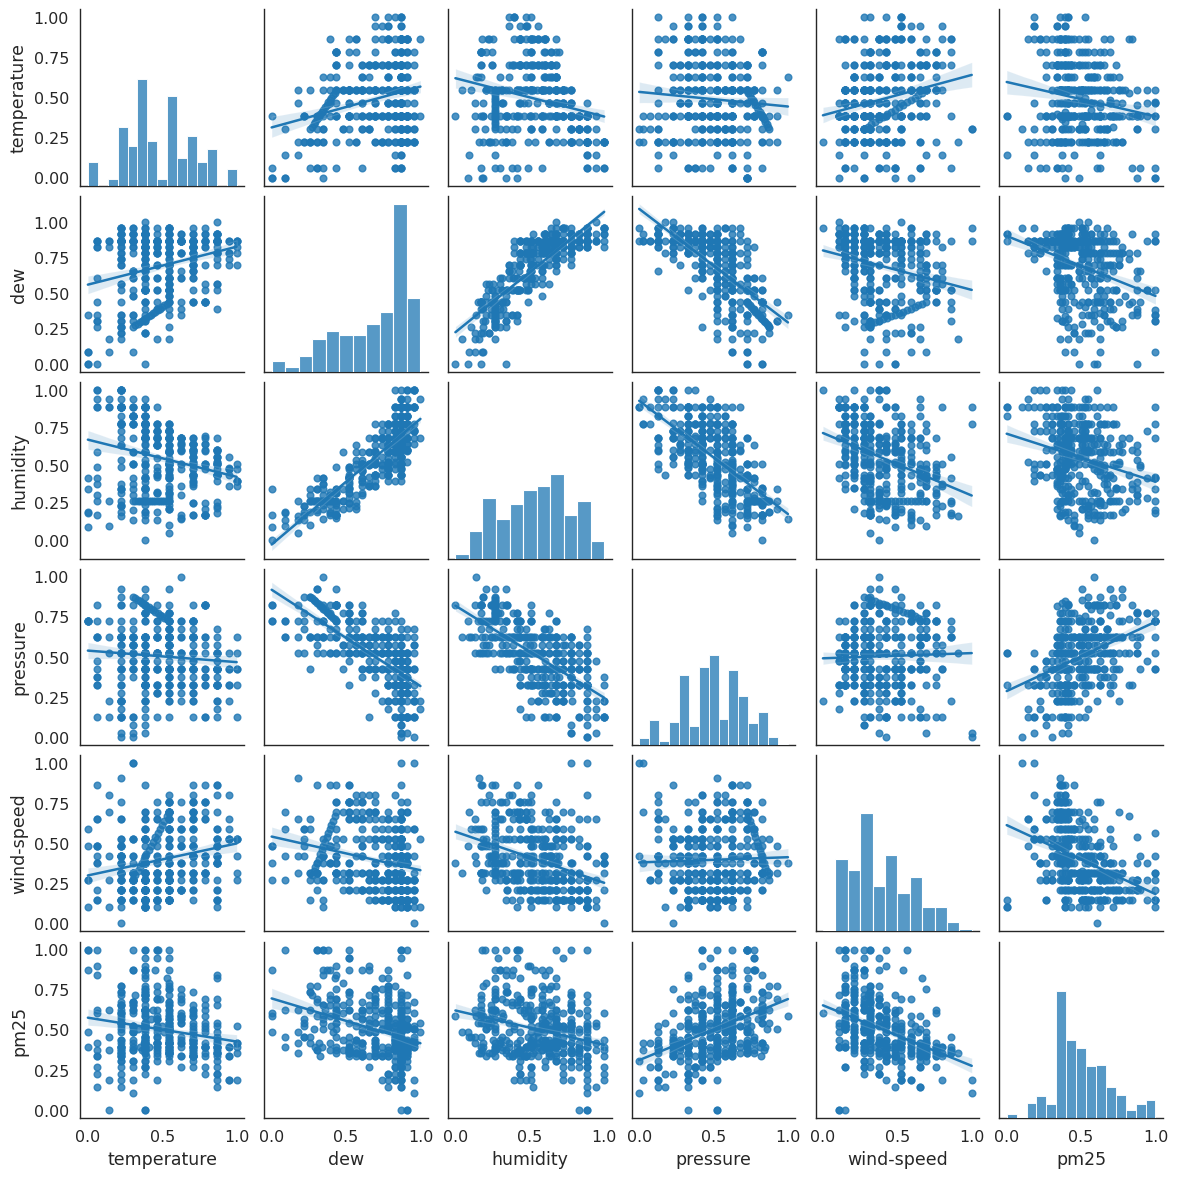

In [91]:
# Scale dữ liệu
plot_scaler = MinMaxScaler(feature_range=(0, 1))
plot_scaler = plot_scaler.fit_transform(df_wide.values.astype('float32'))

# Chuyển lại thành DataFrame để seaborn hiểu
scaled_df = pd.DataFrame(plot_scaler, index=df_wide.index, columns=df_wide.columns)

# Vẽ pairplot
sns.pairplot(scaled_df, kind='reg', height=2, aspect=1)
# plt.suptitle('Scatter plot cho các cặp đặc trưng (đã scale)', y=1.02)
plt.show()

#Các hàm tính toán

In [92]:
seed = 100
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

def parse(x):
        return datetime.strptime(x, '%Y %m %d %H')

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        """
        Biến đổi một chuỗi thời gian thành một dataset học có giám sát.

        Tham số:
            data: Dãy quan sát dưới dạng list hoặc mảng NumPy.
            n_in: Số bước trễ dùng làm đầu vào (X).
            n_out: Số bước quan sát dùng làm đầu ra (y).
            dropnan: Kiểu Boolean cho biết có bỏ các hàng chứa giá trị NaN hay không.

        Trả về:
            Pandas DataFrame của chuỗi thời gian đã được biến đổi phục vụ cho học có giám sát.
        """

        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        #Tạo chuỗi input (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # Tạo chuỗi dự đoán (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # Kết hợp lại
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # Bỏ dòng Nan
        if dropnan:
                agg.dropna(inplace=True)
        return agg

def cnn_model():
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'),
                              input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    # chuyển thành vector để vào Dense
    model.add(TimeDistributed(Flatten()))
    # fully-connected
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', 'mape'])
    return model

######################################################################
def lstm_model(input_shape): ## LSTM
    model = Sequential()
    model.add(LSTM(units = 64, activation='relu', return_sequences = True, input_shape =input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units = 64, activation='relu', return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae','mse','mape'])
    return model

#########################################
def bilstm_model(input_shape): ## Bi-LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 64, activation='relu', return_sequences = True), input_shape = input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units = 64, activation='relu', return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units = 64, activation='relu')))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae','mse','mape'])
    return model

def cnn_lstm_model(): ## CNN - LSTM
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='relu',return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    return model


def cnn_bilstm_model(): ## CNN - BiLSTM
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    return model

def cnn_bilstm_model_ver2(): ## CNN - BiLSTM - v2
    model = Sequential()
    model.add(TimeDistributed(SeparableConv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(SeparableConv1D(filters=32, kernel_size=2,activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(32, activation='relu',return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32)))
    # model.add(Dense(128))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    return model

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(inv_y,inv_yhat):
        # Tính các metrics
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        mse = mean_squared_error(inv_y, inv_yhat)
        mae = mean_absolute_error(inv_y, inv_yhat)
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        return rmse, mse, mae, mape

In [93]:
df_sample = pd.DataFrame(df_wide)
values = df_sample.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))  # Scaling trong khoảng 0-1
#Chia dữ liệu 80% train và 20% test
n_time_split = int(df_wide.shape[0]*0.8)
train = values[:n_time_split]
test  = values[n_time_split:]

train_scaled = scaler.fit_transform(train.astype('float32'))
test_scaled  = scaler.transform(test.astype('float32'))

reframed_train = series_to_supervised(train_scaled, 1, 1)
reframed_train.drop(reframed_train.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed_train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.771601,0.434783,0.169811,0.825005,0.315789,0.695,0.771601
2,0.771601,0.434783,0.169811,0.825005,0.315789,0.625,0.771601
3,0.771601,0.434783,0.169811,0.825005,0.315789,0.545,0.771601
4,0.771601,0.434783,0.169811,0.825005,0.315789,0.585,0.771601
5,0.771601,0.434783,0.169811,0.825005,0.315789,0.655,0.342934


In [94]:
# Tạo supervised cho test
reframed_test = series_to_supervised(test_scaled, 1, 1)
reframed_test.drop(reframed_test.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed_test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.342934,0.782609,0.641509,0.625000,0.378947,0.775,0.514400
2,0.514400,0.782609,0.632075,0.575005,0.210526,0.875,0.342934
3,0.342934,0.782609,0.679245,0.625000,0.315789,0.625,0.514400
4,0.514400,0.782609,0.594340,0.675003,0.421053,0.525,0.428667
5,0.428667,0.608696,0.311321,0.625000,0.421053,0.565,0.342934


In [95]:
train = reframed_train.values
test  = reframed_test.values

# Chia thành input và output
train_X, train_y = train[:, :-1], train[:, -1]
test_X,  test_y  = test[:, :-1],  test[:, -1]

# reshape input thành chuỗi 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### CNN-Bi-LSTM
n_steps, n_features = train_X.shape[2], train_X.shape[1]
n_seq = 1 #Không chia đoạn vì Bi-lstm
train_X= train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features)) ### CNN - LSTM / CNN - BiLSTM
test_X = test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))  ### CNN - LSTM / CNN - BiLSTM

#Define Model
model = cnn_bilstm_model_ver2()
# print("Model CNN-BiLSTM v2 - Use SeparableConv1D")
print(model.summary())

(309, 1, 6) (309,) (77, 1, 6) (77,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_20             │ (None, None, 5, 32)    │            66 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, None, 5, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, None, 4, 32)    │         1,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, None, 4, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,299 (262.89 KB)

 Trainable params: 67,299 (262.89 KB)

 Non-trainable params: 0 (0.00 B)

None








#Huấn luyện mô hình

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.2690 - mae: 0.4654 - mape: 109275.4688 - mse: 0.2690 - val_loss: 0.0933 - val_mae: 0.2666 - val_mape: 4490956.5000 - val_mse: 0.0933
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2194 - mae: 0.4122 - mape: 1725179.6250 - mse: 0.2194 - val_loss: 0.0602 - val_mae: 0.2125 - val_mape: 11517649.0000 - val_mse: 0.0602
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1490 - mae: 0.3244 - mape: 4480703.5000 - mse: 0.1490 - val_loss: 0.0317 - val_mae: 0.1456 - val_mape: 25625452.0000 - val_mse: 0.0317
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0636 - mae: 0.2013 - mape: 10433051.0000 - mse: 0.0636 - val_loss: 0.1137 - val_mae: 0.2980 - val_mape: 49866436.0000 - val_mse: 0.1137
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0699 - mae: 0.2172 - mape: 19837434.0000 - mse: 0.0699 - val_loss: 0.0602 - val_mae: 0.1954 - val_mape: 40223908.0000 - val_mse: 0.0602
Epoch 6/100
11

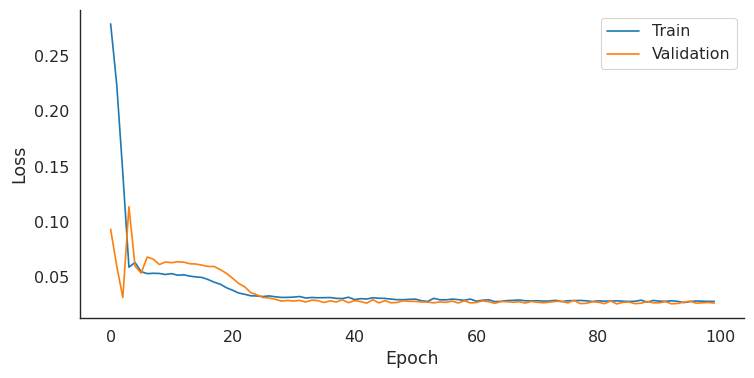

In [96]:
t_train = time.perf_counter()
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_data=(test_X, test_y), verbose=1)
train_secs = time.perf_counter() - t_train


#### Vẽ plot epochs
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.show()

#Dự đoán

In [97]:
t_test = time.perf_counter()
## Dự đoán
yhat = model.predict(test_X)
# print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], 6))
# Đảo ngược scaling giá trị dự đoán
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
#print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Đạo ngược scaling giá trị thực tế
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
test_secs = time.perf_counter() - t_test
rmse, mse, mae, mape = calculate_metrics(inv_y, inv_yhat)

print(f"Training phase: {train_secs:.2f} giây")
print(f"Testing phase: {test_secs:.2f} giây")
print("Test MSE: %.3f" % mse)
print("Test RMSE: %.3f" % rmse)
print("Test MAE: %.3f" % mae)
print("Test MAPE: %.3f" % mape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 978ms/step
Training phase: 28.02 giây
Testing phase: 2.66 giây
Test MSE: 0.907
Test RMSE: 0.952
Test MAE: 0.762
Test MAPE: 2.909


#Trực quan hóa kết quả

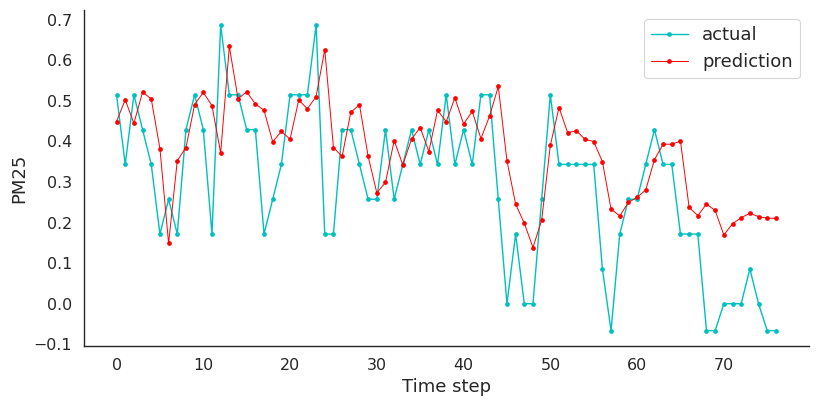

In [98]:
shape = test_y.shape[0]
aa=[x for x in range(shape)] ## test shape
plt.figure(figsize=(8,4))
plt.plot(aa, test_y[:,0][:shape],'c',linewidth=1, marker='.', label="actual")
plt.plot(aa, yhat[:,0][:shape], 'r', linewidth= 0.7, marker='.', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.title('model prediction', fontsize=13)
plt.ylabel('PM25', size=13)
plt.xlabel('Time step', size=13)
plt.legend(fontsize=13)
plt.show()

#So sánh hiệu suất các mô hình

In [99]:
def inverse_and_metrics(yhat, test_X, test_y, scaler):
    # Đảo ngược scaling giá trị dự đoán và thực tế
    yhat = yhat.reshape(-1, 1)
    X_tail = test_X.reshape(test_X.shape[0], -1)[:, -5:]  # lấy 5 cột cuối
    inv_yhat = np.concatenate((yhat, X_tail), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)[:, 0]

    test_y = test_y.reshape(len(test_y), 1)
    inv_y = np.concatenate((test_y, X_tail), axis=1)
    inv_y = scaler.inverse_transform(inv_y)[:, 0]
    rmse, mse, mae, mape = calculate_metrics(inv_y, inv_yhat)
    return inv_y, inv_yhat, rmse, mse, mae, mape

def train_and_evaluate(model, train_X, train_y, test_X, test_y, scaler,
                       epochs=100, batch_size=30, verbose=1, squeeze_yhat=True):
    t_train = time.perf_counter()
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                        validation_data=(test_X, test_y), verbose=verbose)
    train_secs = time.perf_counter() - t_train

    t_test = time.perf_counter()
    yhat = model.predict(test_X, verbose=0)
    if squeeze_yhat and yhat.ndim == 3:
        yhat = yhat.reshape(-1, 1)
    inv_y, inv_yhat, rmse, mse, mae, mape = inverse_and_metrics(yhat, test_X, test_y, scaler)
    test_secs = time.perf_counter() - t_test

    print(f"Training phase: {train_secs:.2f} giây")
    print(f"Testing phase: {test_secs:.2f} giây")
    print("Test MSE: %.3f" % mse)
    print("Test RMSE: %.3f" % rmse)
    print("Test MAE: %.3f" % mae)
    print("Test MAPE: %.3f" % mape)

In [100]:
# LSTM/BiLSTM (3D)
# Nếu train_X ban đầu là 2D (n, 6):
train_X_seq = train_X.reshape((train_X.shape[0], 6, 1))
test_X_seq  = test_X.reshape((test_X.shape[0], 6, 1))


# CNN/CNN-LSTM (4D)
n_seq = 1
train_X_cnn = train_X_seq.reshape((train_X_seq.shape[0], n_seq, n_steps, n_features))
test_X_cnn  = test_X_seq.reshape((test_X_seq.shape[0], n_seq, n_steps, n_features))

##CNN

In [101]:
cnn = cnn_model()
train_and_evaluate(cnn, train_X_cnn, train_y, test_X_cnn, test_y, scaler)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1897 - mae: 0.3700 - mape: 1280546.3750 - mse: 0.1897 - val_loss: 0.0917 - val_mae: 0.2607 - val_mape: 45369612.0000 - val_mse: 0.0917
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0763 - mae: 0.2297 - mape: 18698312.0000 - mse: 0.0763 - val_loss: 0.0508 - val_mae: 0.1779 - val_mape: 36800652.0000 - val_mse: 0.0508
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0583 - mae: 0.1978 - mape: 14140616.0000 - mse: 0.0583 - val_loss: 0.0472 - val_mae: 0.1713 - val_mape: 35604148.0000 - val_mse: 0.0472
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0565 - mae: 0.1970 - mape: 14648893.0000 - mse: 0.0565 - val_loss: 0.0676 - val_mae: 0.2120 - val_mape: 40805228.0000 - val_mse: 0.0676
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0597 - mae: 0.2027 - mape: 16424817.0000 - mse: 0.0597 - val_loss: 0.0522 - val_mae: 0.1803 - val_mape: 37342168.0000 - val_mse: 0.0522
Epoch 6/100
11/11 ━━━━━

##LSTM

In [102]:
lstm = lstm_model(input_shape=(n_steps, n_features))
train_and_evaluate(lstm, train_X_seq, train_y, test_X_seq, test_y, scaler)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.2312 - mae: 0.4241 - mape: 601099.8750 - mse: 0.2312 - val_loss: 0.0302 - val_mae: 0.1436 - val_mape: 22662760.0000 - val_mse: 0.0302
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0711 - mae: 0.2182 - mape: 9994156.0000 - mse: 0.0711 - val_loss: 0.0794 - val_mae: 0.2394 - val_mape: 43100000.0000 - val_mse: 0.0794
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0618 - mae: 0.2072 - mape: 15395371.0000 - mse: 0.0618 - val_loss: 0.0391 - val_mae: 0.1547 - val_mape: 33012148.0000 - val_mse: 0.0391
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0590 - mae: 0.1973 - mape: 13764006.0000 - mse: 0.0590 - val_loss: 0.0657 - val_mae: 0.2089 - val_mape: 40414360.0000 - val_mse: 0.0657
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0597 - mae: 0.1983 - mape: 17786756.0000 - mse: 0.0597 - val_loss: 0.0501 - val_mae: 0.1784 - val_mape: 36508288.0000 - val_mse: 0.0501
Epoch 6/100
11/11 ━━━━━━

##Bi-LSTM

In [103]:
bilstm = bilstm_model(input_shape=(n_steps, n_features))
train_and_evaluate(bilstm, train_X_seq, train_y, test_X_seq, test_y, scaler)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - loss: 0.2461 - mae: 0.4404 - mape: 259391.5938 - mse: 0.2461 - val_loss: 0.0370 - val_mae: 0.1647 - val_mape: 18253022.0000 - val_mse: 0.0370
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0803 - mae: 0.2311 - mape: 8018974.5000 - mse: 0.0803 - val_loss: 0.1039 - val_mae: 0.2848 - val_mape: 47315136.0000 - val_mse: 0.1039
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0694 - mae: 0.2140 - mape: 17078530.0000 - mse: 0.0694 - val_loss: 0.0363 - val_mae: 0.1499 - val_mape: 31786836.0000 - val_mse: 0.0363
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0553 - mae: 0.1916 - mape: 10964956.0000 - mse: 0.0553 - val_loss: 0.0714 - val_mae: 0.2201 - val_mape: 41902564.0000 - val_mse: 0.0714
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0596 - mae: 0.1974 - mape: 15714601.0000 - mse: 0.0596 - val_loss: 0.0487 - val_mae: 0.1748 - val_mape: 36339544.0000 - val_mse: 0.0487
Epoch 6/100
11/11 ━━━━━

##CNN-LSTM

In [104]:

cnn_lstm = cnn_lstm_model()
train_and_evaluate(cnn_lstm, train_X_cnn, train_y, test_X_cnn, test_y, scaler)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.2633 - mae: 0.4593 - mape: 181238.2188 - mse: 0.2633 - val_loss: 0.0663 - val_mae: 0.2236 - val_mape: 9080255.0000 - val_mse: 0.0663
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1301 - mae: 0.2985 - mape: 4773610.0000 - mse: 0.1301 - val_loss: 0.1413 - val_mae: 0.3456 - val_mape: 49556920.0000 - val_mse: 0.1413
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0890 - mae: 0.2405 - mape: 21842534.0000 - mse: 0.0890 - val_loss: 0.0300 - val_mae: 0.1363 - val_mape: 27897590.0000 - val_mse: 0.0300
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0576 - mae: 0.1925 - mape: 12056491.0000 - mse: 0.0576 - val_loss: 0.0638 - val_mae: 0.2083 - val_mape: 39104492.0000 - val_mse: 0.0638
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0580 - mae: 0.1973 - mape: 18653364.0000 - mse: 0.0580 - val_loss: 0.0475 - val_mae: 0.1746 - val_mape: 35286728.0000 - val_mse: 0.0475
Epoch 6/100
11/11 ━━━━━━━━

##PM25-CBL

In [105]:

cnn_bilstm_model = cnn_bilstm_model()
train_and_evaluate(cnn_bilstm_model, train_X_cnn, train_y, test_X_cnn, test_y, scaler)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.2257 - mae: 0.4153 - mape: 430320.0000 - mse: 0.2257 - val_loss: 0.0372 - val_mae: 0.1510 - val_mape: 32310638.0000 - val_mse: 0.0372
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0641 - mae: 0.2033 - mape: 16604314.0000 - mse: 0.0641 - val_loss: 0.0511 - val_mae: 0.1784 - val_mape: 37607824.0000 - val_mse: 0.0511
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0580 - mae: 0.1973 - mape: 14075494.0000 - mse: 0.0580 - val_loss: 0.0522 - val_mae: 0.1796 - val_mape: 38129204.0000 - val_mse: 0.0522
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0525 - mae: 0.1891 - mape: 15007550.0000 - mse: 0.0525 - val_loss: 0.0708 - val_mae: 0.2140 - val_mape: 42840204.0000 - val_mse: 0.0708
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0544 - mae: 0.1899 - mape: 16351465.0000 - mse: 0.0544 - val_loss: 0.0612 - val_mae: 0.1963 - val_mape: 40629296.0000 - val_mse: 0.0612
Epoch 6/100

## Cross validation PM25-CBLo

In [106]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#  Tham số
EPOCHS = 100
BATCH_SIZE = 30

cv_metrics = []
cv_times = []

# 5-fold time-series split
tscv = TimeSeriesSplit(n_splits=5)

for fold, (tr_idx, val_idx) in enumerate(tscv.split(train_X), 1):
    print(f"\n========== FOLD {fold}/5 ==========")
    X_tr, X_val = train_X[tr_idx], train_X[val_idx]
    y_tr, y_val = train_y[tr_idx], train_y[val_idx]

    # Build model
    model = cnn_bilstm_model_ver2()

    # Callbacks
    cbs = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    ]

    # Train
    t0 = time.perf_counter()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=cbs # có hay không kết quả vẫn ko thay đổi
    )
    train_secs = time.perf_counter() - t0

    # Dự đoán & inverse scaling
    y_pred = model.predict(X_val, verbose=0).reshape(-1, 1)
    y_val_true = y_val.reshape(-1, 1)
    # Tạo dummy array để inverse scaling giống code bạn (bám đúng shape)
    y_pred_full = np.concatenate([y_pred, np.zeros((len(y_pred), train_X.shape[2]-1))], axis=1)
    y_val_full = np.concatenate([y_val_true, np.zeros((len(y_val_true), train_X.shape[2]-1))], axis=1)
    inv_y_pred = scaler.inverse_transform(y_pred_full)[:,0]
    inv_y_val = scaler.inverse_transform(y_val_full)[:,0]

    # Tính metric theo thang đo gốc
    rmse, mse, mae, mape = calculate_metrics(inv_y_val, inv_y_pred)
    print(f"FOLD {fold}: RMSE={rmse:.4f}  MAE={mae:.4f}  MAPE={mape:.2f}%  MSE={mse:.4f}")

    cv_metrics.append({'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'MSE': mse})
    cv_times.append(train_secs)

# --- Tổng hợp ---
def report_cv(name):
    vals = [m[name] for m in cv_metrics]
    return np.mean(vals), np.std(vals)

mean_rmse, std_rmse = report_cv('RMSE')
mean_mae, std_mae = report_cv('MAE')
mean_mape, std_mape = report_cv('MAPE')
mean_mse, std_mse = report_cv('MSE')

print("\n========== 5-FOLD CV KẾT QUẢ ==========")
print(f"RMSE : {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"MAE  : {mean_mae:.4f} ± {std_mae:.4f}")
print(f"MAPE : {mean_mape:.2f}% ± {std_mape:.2f}%")
print(f"MSE  : {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Trung bình thời gian training/fold: {np.mean(cv_times):.2f}s")



========== FOLD 1/5 ==========
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1679 - mae: 0.3774 - mape: 99.4433 - mse: 0.1679 - val_loss: 0.3302 - val_mae: 0.5630 - val_mape: 98.3157 - val_mse: 0.3302 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1614 - mae: 0.3687 - mape: 96.7422 - mse: 0.1614 - val_loss: 0.3201 - val_mae: 0.5540 - val_mape: 96.6707 - val_mse: 0.3201 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1548 - mae: 0.3597 - mape: 93.9174 - mse: 0.1548 - val_loss: 0.3094 - val_mae: 0.5442 - val_mape: 94.8891 - val_mse: 0.3094 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1479 - mae: 0.3500 - mape: 90.8864 - mse: 0.1479 - val_loss: 0.2977 - val_mae: 0.5334 - val_mape: 92.9278 - val_mse: 0.2977 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1403 - mae: 0.3390 - mape: 87.4301 - mse: 0.1403 - val_loss: 0.2851 - val_mae: 0.5215 - val_mape: 90.7530 - val_mse: 0.285

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - loss: 0.2608 - mae: 0.4819 - mape: 99.4244 - mse: 0.2608 - val_loss: 0.5612 - val_mae: 0.7168 - val_mape: 97.4405 - val_mse: 0.5612 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2436 - mae: 0.4638 - mape: 95.0729 - mse: 0.2436 - val_loss: 0.5352 - val_mae: 0.6984 - val_mape: 94.5032 - val_mse: 0.5352 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2266 - mae: 0.4451 - mape: 90.5557 - mse: 0.2266 - val_loss: 0.5062 - val_mae: 0.6773 - val_mape: 91.1438 - val_mse: 0.5062 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2074 - mae: 0.4230 - mape: 85.2230 - mse: 0.2074 - val_loss: 0.4716 - val_mae: 0.6512 - val_mape: 86.9761 - val_mse: 0.4716 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1851 - mae: 0.3956 - mape: 78.5732 - mse: 0.1851 - val_loss: 0.4281 - val_mae: 0.6167 - val_mape: 81.4780 - val_mse: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.3610 - mae: 0.5563 - mape: 98.7022 - mse: 0.3610 - val_loss: 0.2797 - val_mae: 0.4815 - val_mape: 93.5346 - val_mse: 0.2797 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3317 - mae: 0.5294 - mape: 92.8045 - mse: 0.3317 - val_loss: 0.2503 - val_mae: 0.4500 - val_mape: 85.7428 - val_mse: 0.2503 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2968 - mae: 0.4953 - mape: 85.3614 - mse: 0.2968 - val_loss: 0.2133 - val_mae: 0.4068 - val_mape: 75.0804 - val_mse: 0.2133 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2519 - mae: 0.4478 - mape: 74.9826 - mse: 0.2519 - val_loss: 0.1645 - val_mae: 0.3417 - val_mape: 58.9816 - val_mse: 0.1645 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1911 - mae: 0.3762 - mape: 60.1997 - mse: 0.1911 - val_loss: 0.1030 - val_mae: 0.2562 - val_mape: 44.6656 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.3261 - mae: 0.5250 - mape: 98.0892 - mse: 0.3261 - val_loss: 0.2493 - val_mae: 0.4463 - val_mape: 702928.5625 - val_mse: 0.2493 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2881 - mae: 0.4876 - mape: 89.3054 - mse: 0.2881 - val_loss: 0.2062 - val_mae: 0.3971 - val_mape: 1701325.0000 - val_mse: 0.2062 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2343 - mae: 0.4293 - mape: 75.7560 - mse: 0.2343 - val_loss: 0.1428 - val_mae: 0.3180 - val_mape: 3454101.7500 - val_mse: 0.1428 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1553 - mae: 0.3302 - mape: 54.5673 - mse: 0.1553 - val_loss: 0.0660 - val_mae: 0.2020 - val_mape: 6882769.0000 - val_mse: 0.0660 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0635 - mae: 0.2020 - mape: 40.0266 - mse: 0.0635 - val_loss: 0.0862 - val_mae: 0.2406 - val_mape: 12

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.3328 - mae: 0.5299 - mape: 37433.5273 - mse: 0.3328 - val_loss: 0.0964 - val_mae: 0.2718 - val_mape: 2712890.7500 - val_mse: 0.0964 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2951 - mae: 0.4931 - mape: 103739.8047 - mse: 0.2951 - val_loss: 0.0741 - val_mae: 0.2331 - val_mape: 6334218.0000 - val_mse: 0.0741 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2480 - mae: 0.4429 - mape: 204954.1719 - mse: 0.2480 - val_loss: 0.0480 - val_mae: 0.1764 - val_mape: 11891648.0000 - val_mse: 0.0480 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1844 - mae: 0.3658 - mape: 354329.0625 - mse: 0.1844 - val_loss: 0.0262 - val_mae: 0.1359 - val_mape: 21778778.0000 - val_mse: 0.0262 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1010 - mae: 0.2544 - mape: 595333.0000 - mse: 0.1010 - val_loss: 0.0701 - val_mae: